In [3]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from gwaxion import physics

import multiprocessing
from functools import partial

mplparams = {
    'text.usetex': True,  # use LaTeX for all text
    'axes.linewidth': 1,  # set axes linewidths to 0.5
    'axes.grid': False,  # add a grid
    'axes.labelweight': 'normal',
    'font.family': 'serif',
    'font.size': 24,
    'font.serif': 'Computer Modern Roman'
}
matplotlib.rcParams.update(mplparams)

cmap = 'magma'

In [4]:
reload(physics)

<module 'gwaxion.physics' from '/home/misi/.local/lib/python2.7/site-packages/gwaxion/physics.pyc'>

Let's obtain and plot GW amplitudes and frequencies for a range of $\alpha$'s for the following black hole:

In [34]:
bh = physics.BlackHole(mass=60, chi=0.7, msun=True)
distance = 5E6 * physics.PC_SI

alphas = np.arange(0.01, 0.25, 0.001)

To use `multiprocessing` we need top-level-defined functions, which we will used instead of the functions already defined in the `physics` module.

In [35]:
def get_peak(a, lgw=2, **kwargs): 
    cloud = physics.BosonCloud.from_parameters(1, 1, 0,alpha=a, **kwargs) 
    return cloud.gw(lgw).h0r, cloud.gw(lgw).f

# collect peak values
ncpus = 8
pool = multiprocessing.Pool(ncpus)
h0r_fs = pool.map(partial(get_peak, m_bh=bh.mass_msun, chi_bh=bh.chi), alphas)

h0rs_num, fgws_num = np.array(h0r_fs).T

# h0rs are the amplitudes 1m away from the source, so rescale by actual distance
h0s_num = h0rs_num / distance

Let's compare the above results, computed by numerically solving the cloud evolution DEs, to those approximating the final mass by the initial mass for part of the calculation:

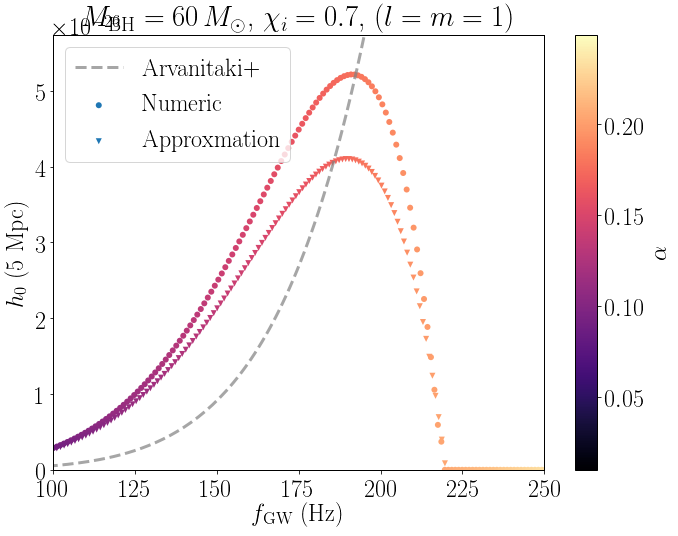

In [36]:
# Brito approximation
h0s_2, fgws_2 = physics.h0_scalar_brito(bh.mass_msun, alphas, chi_i=bh.chi, d=distance)
# Arvanitaki approximation
h0s_3, fgws_3 = physics.h0_scalar_approx(alphas, m_bh=bh.mass_msun, d=distance)

fig, ax = plt.subplots(1, figsize=(11,8))

ax.scatter(fgws_num, h0s_num, c=alphas, edgecolor='none', label='Numeric', cmap=cmap)
s = ax.scatter(fgws_2, h0s_2, c=alphas, edgecolor='none', label='Approxmation', cmap=cmap, marker='v')#, vmin=0, vmax=0.25)
ax.plot(fgws_3, h0s_3, lw=3, color='gray', ls='--', alpha=0.7, label="Arvanitaki+")

cb = plt.colorbar(s, label=r'$\alpha$')
ax.set_xlim(100, 250)
ax.set_ylim(0, max(np.nanmax(h0s_2)*1.1, np.nanmax(h0s_num)*1.1))
ax.set_xlabel(r"$f_{\rm GW}$ (Hz)")
ax.set_ylabel(r"$h_0$ (5 Mpc)")
ax.set_title(r"$M_{\rm BH}=60\,M_\odot$, $\chi_i=0.7$, $(l=m=1)$")
ax.legend(loc="upper left", numpoints=1)
plt.show(fig)

In [42]:
# let's try this for different parameters

alphas = np.arange(0.01, 0.5, 0.001)

bh = physics.BlackHole(mass=60, chi=0.9, msun=True)

h0r_fs = pool.map(partial(get_peak, m_bh=bh.mass_msun, chi_bh=bh.chi), alphas)
h0rs_num, fgws_num = np.array(h0r_fs).T
h0s_num = h0rs_num / distance

# Brito approximation
h0s_2, fgws_2 = physics.h0_scalar_brito(bh.mass_msun, alphas, chi_i=bh.chi, d=distance)
# Arvanitaki approximation
h0s_3, fgws_3 = physics.h0_scalar_approx(alphas, m_bh=bh.mass_msun, d=distance)

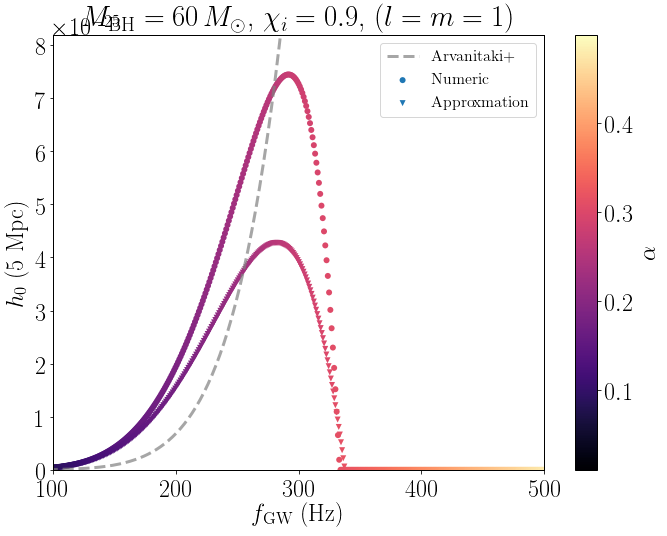

In [43]:
fig, ax = plt.subplots(1, figsize=(11,8))
ax.scatter(fgws_num, h0s_num, c=alphas, edgecolor='none', label='Numeric', cmap=cmap)
s = ax.scatter(fgws_2, h0s_2, c=alphas, edgecolor='none', label='Approxmation', cmap=cmap, marker='v')
ax.plot(fgws_3, h0s_3, lw=3, color='gray', ls='--', alpha=0.7, label="Arvanitaki+")

cb = plt.colorbar(s, label=r'$\alpha$')
ax.set_xlim(100, 500)
ax.set_ylim(0, max(np.nanmax(h0s_2)*1.1, np.nanmax(h0s_num)*1.1))
ax.set_xlabel(r"$f_{\rm GW}$ (Hz)")
ax.set_ylabel(r"$h_0$ (5 Mpc)")
ax.set_title(r"$M_{\rm BH}=60\,M_\odot$, $\chi_i=0.9$, $(l=m=1)$")
ax.legend(loc="upper right", numpoints=1, fontsize=16)
plt.show(fig)

In [45]:
max(h0r_fs)

(0.11488619196896936, 291.5009734116684)

In [47]:
max(h0rs_num)

0.11488619196896936

In [48]:
a = h0r_fs
a.append([np.nan, 0])

max(a)

(0.11488619196896936, 291.5009734116684)

In [49]:
a[-1]

[nan, 0]